In [1]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 200 (delta 66), reused 164 (delta 33), pack-reused 0
Receiving objects: 100% (200/200), 32.12 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
! pip install transformers plotly datasets

In [1]:
import sys

sys.path.append('space-model')

In [2]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from datasets import load_dataset, Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

from logger import get_logger
from train import training, eval_results, plot_results, eval, eval_epoch

/home/stepan/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
SEED = 42

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=SEED)

In [5]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')

    return wrapper

In [6]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda


@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used // 1024 ** 2} MB.")
    except Exception as e:
        print(e)


@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

Defaulting to user installation because normal site-packages is not writeable


In [7]:
device_id = 1

In [8]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [9]:
if torch.cuda.is_available():
    torch.cuda.set_device(device)

In [10]:
MODEL_NAME = 'facebook/bart-base'

DATASET_NAME = 'go-emotions'

NUM_LABELS = 28
N_LATENT = 32

NUM_EPOCHS = 5
BATCH_SIZE = 32
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-4
MAX_GRAD_NORM = 1000

In [11]:
emotions_1_df = pd.read_csv(f'data/goemotions_1.csv')
emotions_2_df = pd.read_csv(f'data/goemotions_2.csv')
emotions_3_df = pd.read_csv(f'data/goemotions_3.csv')

emotions_df = pd.concat([
    emotions_1_df,
    emotions_2_df,
    emotions_3_df
], ignore_index=True, axis=0)
emotions_df

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
labels = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral'
]

In [13]:
emotions_df['label'] = emotions_df[labels].apply(lambda x: x.to_list(), axis=1)
emotions_df

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,label
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
211221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
211222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
211223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
train_split, test_split = train_test_split(emotions_df, test_size=0.2, random_state=SEED)
test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=SEED)

In [15]:
dataset = DatasetDict({
    'emotions_train': Dataset.from_pandas(train_split[['text', 'label']]),
    'emotions_val': Dataset.from_pandas(test_split[['text', 'label']]),
    'emotions_test': Dataset.from_pandas(val_split[['text', 'label']]),
})
dataset

DatasetDict({
    emotions_train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 168980
    })
    emotions_val: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 21122
    })
    emotions_test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 21123
    })
})

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BartTokenizerFast(name_or_path='facebook/bart-base', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

In [17]:
tokenized_dataset = dataset
tokenized_dataset = tokenized_dataset.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN,
                        return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/21122 [00:00<?, ? examples/s]

Map:   0%|          | 0/21123 [00:00<?, ? examples/s]

DatasetDict({
    emotions_train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 168980
    })
    emotions_val: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 21122
    })
    emotions_test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 21123
    })
})

In [18]:
raw_model_base = AutoModel.from_pretrained(MODEL_NAME).to(device)
raw_model_base

BartModel(
  (shared): Embedding(50265, 768, padding_idx=1)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50265, 768, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding)

In [18]:
class BertForMultilabelOutput:
    def __init__(self, loss, logits):
        self.loss = loss
        self.logits = logits


class BertForMultilabelClassification(torch.nn.Module):
    def __init__(self, model, num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.num_labels = num_labels

        self.bert = model
        self.device = model.device

        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, num_labels)

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pooled_output = outputs.pooler_output
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits.view(-1, self.num_labels),
                                                      labels.view(-1, self.num_labels).float())

        return BertForMultilabelOutput(loss, logits)

In [37]:
raw_model = BertForMultilabelClassification(raw_model_base, NUM_LABELS).to(device)

In [38]:
# raw_model.load_state_dict(torch.load(f'models/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin'))

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
# for p in raw_model.bert.parameters():
#     p.requires_grad = False
# for p in raw_model.bert.parameters():
#     p.requires_grad = False

In [41]:
count_parameters(raw_model)

139441948

In [20]:
def get_preds_from_logits(outputs):
    return outputs.loss, (outputs.logits >= 0).long(), outputs.logits

In [21]:
config = {
    'experiment_name': 'default',
    'log_terminal': True,

    'dataset_name': DATASET_NAME,
    'model_name': MODEL_NAME,

    'num_labels': NUM_LABELS,
    'num_epochs': NUM_EPOCHS,
    'iterations': 1,

    'max_seq_len': MAX_SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'lr': LEARNING_RATE,
    'fp16': False,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
    'num_warmup_steps': 0,
    'gradient_accumulation_steps': 1,

    # funcs:
    'preds_from_logits_func': get_preds_from_logits
}

In [22]:
base_name = f'{DATASET_NAME}-{MODEL_NAME.replace("/", "_")}-{NUM_EPOCHS}'
base_name

'go-emotions-facebook_bart-base-5'

In [45]:
log = get_logger(f'logs/{config["experiment_name"]}', base_name)

In [46]:
base_history = training(raw_model, tokenized_dataset['emotions_train'], tokenized_dataset['emotions_val'], log, config)

2024-06-16 09:56:15,289 - default.terminal - DEBUG - Train steps: 26403
2024-06-16 09:56:15,291 - default.terminal - DEBUG - Steps per epoch: 5280.625
2024-06-16 09:56:15,292 - default.terminal - INFO - Epoch: 1
100%|█████████████████████████████████████████| 661/661 [03:57<00:00,  2.79it/s]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-06-16 11:32:20,392 - default.terminal - INFO - 
2024-06-16 11:32:20,393 - default.termin

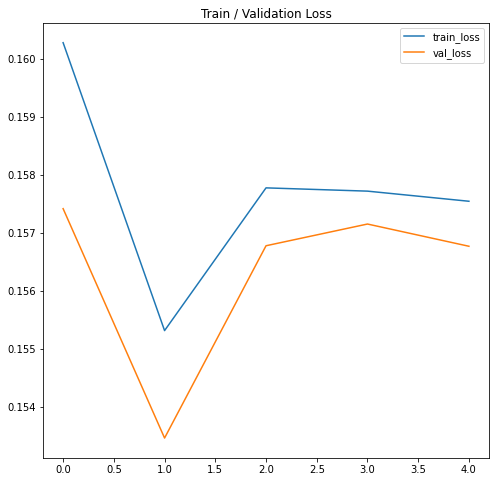

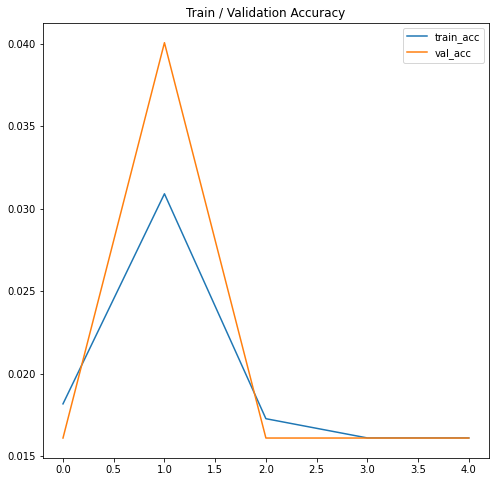

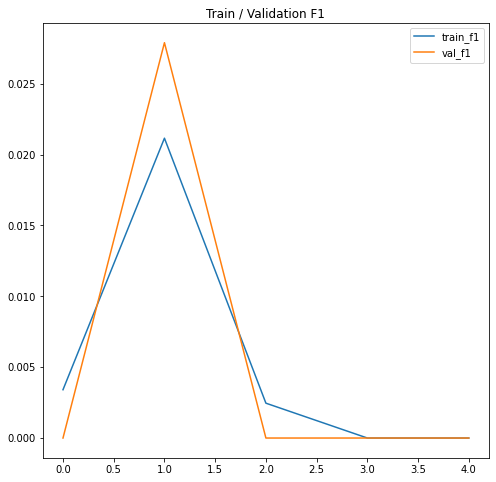

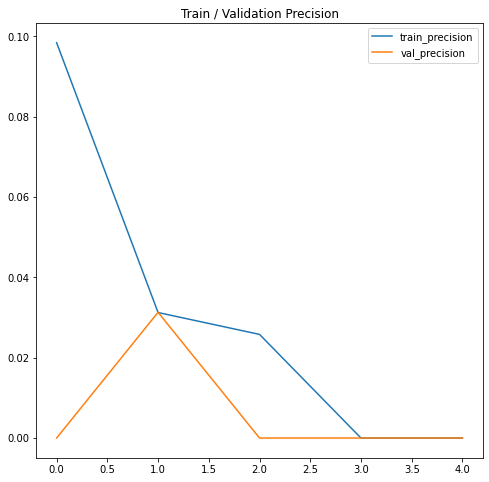

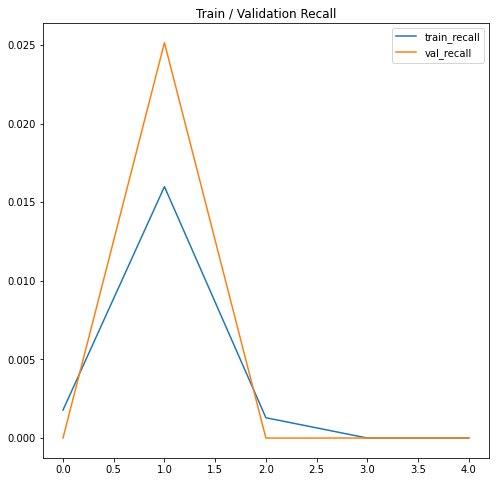

In [47]:
plot_results(log, base_history, plot_name='base_history')

In [23]:
def save_model(model, config, name):
    if not os.path.exists(f'models/{config["experiment_name"]}'):
        os.makedirs(f'models/{config["experiment_name"]}', exist_ok=True)
    full_model_path = f'models/{config["experiment_name"]}/{name}.bin'
    torch.save(model.state_dict(), full_model_path)
    return full_model_path

In [49]:
base_name

'go-emotions-facebook_bart-base-5'

In [50]:
save_model(raw_model, config, base_name)

'models/default/go-emotions-facebook_bart-base-5.bin'

In [24]:
test_dataloader = torch.utils.data.DataLoader(tokenized_dataset['emotions_test'], batch_size=config['batch_size'])

In [52]:
eval_results(log, base_name, raw_model, test_dataloader, config)

100%|█████████████████████████████████████████| 661/661 [03:55<00:00,  2.81it/s]
/home/stepan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-06-16 18:01:38,020 - default.terminal - INFO - Val loss: 0.15706929308608872
2024-06-16 18:01:38,021 - default.terminal - INFO - Val acc: 0.01656961605832505
2024-06-16 18:01:38,022 - default.terminal - INFO - Val f1: 0.0
2024-06-16 18:01:38,022 - default.terminal - INFO - Val precision: 0.0
2024-06-16 18:01:38,023 - default.terminal - INFO - Val recall: 0.0


In [53]:
# source:
# https://emotiontypology.com/positive_emotion/positivesurprise/

In [25]:
defintions = [
    {'emotion': 'admiration',
     'definition': 'The feeling when you look up to someone who has excellent abilities or has accomplished impressive things. You have the urge to also achieve such things and be more like this person.'},
    {'emotion': 'amusement',
     'definition': 'The feeling when you encounter something silly, ironic, witty, or absurd, which makes you laugh. You have the urge to be playful and share the joke with others.'},
    {'emotion': 'anger',
     'definition': 'The feeling when someone did something bad that harmed or offended you. You want to go against this person to stop them or prevent them from doing it again.'},
    {'emotion': 'annoyance',
     'definition': 'The feeling when something is happening that bothers you. You have the urge to say or do something to change it or make it stop.'},
    {'emotion': 'approval',
     'definition': 'The feeling when you agree with or accept something. You have the urge to support or encourage it.'},
    {'emotion': 'caring',
     'definition': 'The feeling when you are concerned about someone or something. You have the urge to help or protect them.'},
    {'emotion': 'confusion',
     'definition': 'The feeling when you get information that does not make sense to you, leaving you uncertain what to do with it.'},
    {'emotion': 'curiosity',
     'definition': 'The feeling when you want to know more about something. You have the urge to explore and learn.'},
    {'emotion': 'desire', 'definition': 'The feeling when you want something. You have the urge to get it.'},
    {'emotion': 'disappointment',
     'definition': 'The feeling when something you hoped for did not happen. You have the urge to express your sadness and frustration.'},
    {'emotion': 'disapproval',
     'definition': 'The feeling when you disagree with or dislike something. You have the urge to criticize or oppose it.'},
    {'emotion': 'disgust',
     'definition': 'The feeling when you encounter something that you don’t want to get into contact with in any way (neither see, hear, feel, smell, or taste it), because you expect it is bad for you. You want to get it away from you.'},
    {'emotion': 'embarrassment',
     'definition': 'The feeling when people suddenly focus unwanted attention on you in a situation that is not in your control. You have the urge to get away from the attention.'},
    {'emotion': 'excitement',
     'definition': 'The feeling when you expect something good or nice will happen to you. You cannot wait for it to happen.'},
    {'emotion': 'fear',
     'definition': 'The feeling when you encounter or think about a thing or person that can harm you. You have the urge to avoid or get away from the threat.'},
    {'emotion': 'gratitude',
     'definition': 'The feeling when you think that someone has gone out of their way to do something good or nice for you. You have the urge to do something back and get closer to this person.'},
    {'emotion': 'grief',
     'definition': 'The feeling when you have lost something or someone that was important to you. You have the urge to express your sadness and cry.'},
    {'emotion': 'joy',
     'definition': 'The feeling when you are happy. You have the urge to smile and be friendly to others.'},
    {'emotion': 'love',
     'definition': 'The feeling when you care deeply about someone or something. You have the urge to get closer to this person or thing.'},
    {'emotion': 'nervousness',
     'definition': 'The feeling when you have to do something, but you think that something might go wrong that prevents you from succeeding. You don’t feel in control of the situation.'},
    {'emotion': 'optimism',
     'definition': 'The feeling when you think that something good or nice will happen to you. You have the urge to be positive and look forward to it.'},
    {'emotion': 'pride',
     'definition': 'The feeling when you possess or have accomplished something that other people find praiseworthy. You feel vigorous and have the urge to show off to others.'},
    {'emotion': 'realization',
     'definition': 'The feeling when you suddenly understand something that you did not understand before. You have the urge to act on this new understanding.'},
    {'emotion': 'relief',
     'definition': 'The feeling when an unpleasant experience is finally over, or when you find out that something you had dreaded has not happened (or will not happen). You can finally take your mind off it.'},
    {'emotion': 'remorse',
     'definition': 'The feeling when you have done something wrong and you feel sorry about it. You have the urge to apologize and make amends.'},
    {'emotion': 'sadness',
     'definition': 'The feeling when you lost something that was important to you. You have the urge to withdraw and to seek comfort.'},
    {'emotion': 'surprise',
     'definition': 'The feeling when something unexpected happens. You have the urge to pay attention to it and to find out more about it.'},
    {'emotion': 'neutral', 'definition': 'The feeling when you don’t feel any particular emotion.'}
]

In [26]:
emotions_defitions_df = pd.DataFrame([{**d, 'label': labels.index(d['emotion'])} for d in defintions])
emotions_defitions_df

,emotion,definition,label
0,admiration,The feeling when you look up to someone who ha...,0
1,amusement,The feeling when you encounter something silly...,1
2,anger,The feeling when someone did something bad tha...,2
3,annoyance,The feeling when something is happening that b...,3
4,approval,The feeling when you agree with or accept some...,4
5,caring,The feeling when you are concerned about someo...,5
6,confusion,The feeling when you get information that does...,6
7,curiosity,The feeling when you want to know more about s...,7
8,desire,The feeling when you want something. You have ...,8
9,disappointment,The feeling when something you hoped for did n...,9


In [27]:
emotions_defitions_df['text'] = emotions_defitions_df['emotion'] + ' - ' + emotions_defitions_df['definition']

definitions_dataset = DatasetDict({
    'definitions': Dataset.from_pandas(emotions_defitions_df[['text', 'label']]),
})
definitions_dataset

DatasetDict({
    definitions: Dataset({
        features: ['text', 'label'],
        num_rows: 28
    })
})

In [28]:
tokenized_definitions_dataset = definitions_dataset.map(
    lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN,
                        return_tensors='pt'),
    batched=True)

tokenized_definitions_dataset.set_format('torch', device=device)

tokenized_definitions_dataset

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

DatasetDict({
    definitions: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 28
    })
})

In [29]:
@eval
def create_base_knowledge_embeddings(model, dataloader):
    knowledge_embeds, knowledge_texts, knowledge_labels = [], [], []
    with torch.no_grad():
        for step, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
            ids = batch['input_ids'].to(device, dtype=torch.long)
            mask = batch['attention_mask'].to(device, dtype=torch.long)

            projected = model.bert(input_ids=ids, attention_mask=mask)  # (B, seq_len, 768)

            # knowledge_embeds += projected.pooler_output.detach().cpu().tolist()
            knowledge_embeds += projected.last_hidden_state[:, 0, :].detach().cpu().tolist()
            knowledge_texts += batch['text']
            # we need this for further evaluation
            knowledge_labels += [d.item() for d in batch['label']]
    return {'embeds': knowledge_embeds, 'texts': knowledge_texts, 'labels': knowledge_labels}

In [30]:
definitions_dataloader = torch.utils.data.DataLoader(tokenized_definitions_dataset['definitions'],
                                                     batch_size=BATCH_SIZE, shuffle=False)

In [60]:
knowledge_dict = create_base_knowledge_embeddings(raw_model, definitions_dataloader)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


In [61]:
len(knowledge_dict['embeds'][0])

768

In [62]:
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(knowledge_dict['embeds'])

NearestNeighbors(metric='euclidean', n_neighbors=1)

In [31]:
@eval
def eval_base_knowledge_embeds(model, knn, dataloader, knowledge_dict):
    explained_embeds, explained_texts, explained_labels = [], [], []
    neigh_explained_texts, neigh_explained_labels = [], []
    neigh_explained_embeds = []
    with torch.no_grad():
        for step, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
            ids = batch['input_ids'].to(device, dtype=torch.long)
            mask = batch['attention_mask'].to(device, dtype=torch.long)

            projected = model.bert(input_ids=ids, attention_mask=mask)  # (B, seq_len, 768)

            # raw_embeds = projected.pooler_output.detach().cpu().tolist()  # (B, 768)
            raw_embeds = projected.last_hidden_state[:, 0, :].detach().cpu().tolist()  # (B, 768)
            neighbors_ids = knn.kneighbors(raw_embeds, return_distance=False)  # (B, k), k neighbors ids for each sample

            k_neigh_texts = [[knowledge_dict['texts'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k)
            k_neigh_embeds = [[knowledge_dict['embeds'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k, 768)
            k_neigh_labels = [[knowledge_dict['labels'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k)

            explained_embeds += raw_embeds  # (t, 768)
            explained_texts += batch['text']  # (t)
            explained_labels += batch['label'].cpu().tolist()  # (t)
            neigh_explained_texts += k_neigh_texts  # (t, k)
            neigh_explained_embeds += k_neigh_embeds  # (t, k, 768)
            neigh_explained_labels += k_neigh_labels  # (t, k)

    return {
        'embeds': explained_embeds,
        'texts': explained_texts,
        'labels': explained_labels,
        'neigh_texts': neigh_explained_texts,
        'neigh_embeds': neigh_explained_embeds,
        'neigh_labels': neigh_explained_labels
    }

In [64]:
explained_dict = eval_base_knowledge_embeds(raw_model, knn, test_dataloader, knowledge_dict)

  0%|                                                   | 0/661 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|█████████████████████████████████████████| 661/661 [03:57<00:00,  2.78it/s]


In [32]:
def get_indices(lst):
    return [i for i in range(len(lst)) if lst[i] == 1]

In [66]:
explained_dict['texts'][0], get_indices(explained_dict['labels'][0]), explained_dict['neigh_texts'][0], \
explained_dict['neigh_labels'][0]

('Nice try Lumi',
 [4],
 ['disapproval - The feeling when you disagree with or dislike something. You have the urge to criticize or oppose it.'],
 [10])

In [67]:
len(explained_dict['embeds'][0])

768

In [68]:
knowledge_df = pd.DataFrame(knowledge_dict)
explained_df = pd.DataFrame(explained_dict)
knowledge_df

,embeds,texts,labels
0,"[0.3029230237007141, 0.3993091285228729, 0.089...",admiration - The feeling when you look up to s...,0
1,"[0.3029230833053589, 0.3993091881275177, 0.089...",amusement - The feeling when you encounter som...,1
2,"[0.3029230535030365, 0.3993091583251953, 0.089...",anger - The feeling when someone did something...,2
3,"[0.3029230535030365, 0.3993091285228729, 0.089...",annoyance - The feeling when something is happ...,3
4,"[0.3029229938983917, 0.3993090093135834, 0.089...",approval - The feeling when you agree with or ...,4
5,"[0.3029230237007141, 0.3993090093135834, 0.089...",caring - The feeling when you are concerned ab...,5
6,"[0.3029230237007141, 0.39930903911590576, 0.08...",confusion - The feeling when you get informati...,6
7,"[0.3029230237007141, 0.39930909872055054, 0.08...",curiosity - The feeling when you want to know ...,7
8,"[0.3029230237007141, 0.39930909872055054, 0.08...",desire - The feeling when you want something. ...,8
9,"[0.3029230237007141, 0.39930909872055054, 0.08...",disappointment - The feeling when something yo...,9


In [69]:
explained_df

,embeds,texts,labels,neigh_texts,neigh_embeds,neigh_labels
0,"[0.3029230535030365, 0.3993091285228729, 0.089...",Nice try Lumi,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disapproval - The feeling when you disagree w...,"[[0.3029230237007141, 0.39930909872055054, 0.0...",[10]
1,"[0.30292296409606934, 0.39930909872055054, 0.0...","Thank you, you're awesome","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11]
2,"[0.3029230833053589, 0.3993091285228729, 0.089...",lol at them both getting downvotes,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11]
3,"[0.3029231131076813, 0.3993090093135834, 0.089...","> the fact that it is illegal Watch out, we've...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[amusement - The feeling when you encounter so...,"[[0.3029230833053589, 0.3993091881275177, 0.08...",[1]
4,"[0.3029230237007141, 0.39930906891822815, 0.08...","I meant we as in the group, sorry if that was ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[excitement - The feeling when you expect some...,"[[0.3029230535030365, 0.39930909872055054, 0.0...",[13]
...,...,...,...,...,...,...
21118,"[0.3029229938983917, 0.39930906891822815, 0.08...",You. I like you.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[admiration - The feeling when you look up to ...,"[[0.3029230237007141, 0.3993091285228729, 0.08...",[0]
21119,"[0.3029231131076813, 0.3993090093135834, 0.089...",Well except for keeping it around as it is onl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11]
21120,"[0.3029230833053589, 0.3993090093135834, 0.089...",Thanks 💙 ice skating is also one of my favouri...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[embarrassment - The feeling when people sudde...,"[[0.3029230237007141, 0.399308979511261, 0.089...",[12]
21121,"[0.3029231131076813, 0.3993091285228729, 0.089...",I'm not to proud of them right now. I'm mad at...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[embarrassment - The feeling when people sudde...,"[[0.3029230237007141, 0.399308979511261, 0.089...",[12]


In [70]:
explained_df['neigh_labels_oh'] = explained_df['neigh_labels'].apply(
    lambda x: [1 if i in x else 0 for i in range(NUM_LABELS)])
explained_df

,embeds,texts,labels,neigh_texts,neigh_embeds,neigh_labels,neigh_labels_oh
0,"[0.3029230535030365, 0.3993091285228729, 0.089...",Nice try Lumi,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disapproval - The feeling when you disagree w...,"[[0.3029230237007141, 0.39930909872055054, 0.0...",[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[0.30292296409606934, 0.39930909872055054, 0.0...","Thank you, you're awesome","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,"[0.3029230833053589, 0.3993091285228729, 0.089...",lol at them both getting downvotes,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,"[0.3029231131076813, 0.3993090093135834, 0.089...","> the fact that it is illegal Watch out, we've...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[amusement - The feeling when you encounter so...,"[[0.3029230833053589, 0.3993091881275177, 0.08...",[1],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0.3029230237007141, 0.39930906891822815, 0.08...","I meant we as in the group, sorry if that was ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[excitement - The feeling when you expect some...,"[[0.3029230535030365, 0.39930909872055054, 0.0...",[13],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...,...
21118,"[0.3029229938983917, 0.39930906891822815, 0.08...",You. I like you.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[admiration - The feeling when you look up to ...,"[[0.3029230237007141, 0.3993091285228729, 0.08...",[0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21119,"[0.3029231131076813, 0.3993090093135834, 0.089...",Well except for keeping it around as it is onl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[disgust - The feeling when you encounter some...,"[[0.3029229938983917, 0.3993091285228729, 0.08...",[11],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
21120,"[0.3029230833053589, 0.3993090093135834, 0.089...",Thanks 💙 ice skating is also one of my favouri...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[embarrassment - The feeling when people sudde...,"[[0.3029230237007141, 0.399308979511261, 0.089...",[12],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
21121,"[0.3029231131076813, 0.3993091285228729, 0.089...",I'm not to proud of them right now. I'm mad at...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[embarrassment - The feeling when people sudde...,"[[0.3029230237007141, 0.399308979511261, 0.089...",[12],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [33]:
def cosine_similarity(a, b):
    return np.dot(a, b) / ((np.dot(a, a) ** 0.5) * (np.dot(b, b) ** 0.5))


def euclid_similarity(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def jaccard_similarity(a, b):
    return (np.array(a) & np.array(b)).sum() / (np.array(a) | np.array(b)).sum()

In [34]:
def eval_metrics(knowledge_df, explained_df):
    metrics_dict = {
        'jaccard': [],
        'mean_cosine': [],
        'min_cosine': [],
        'mean_euclid': [],
        'max_euclid': []
    }

    # explained - is reactions with their predicted neighbors
    # knowledge - is definitions

    for explained_record in explained_df.to_dict('records'):
        if len(explained_record['neigh_labels']) == 0:
            print('No neighbors for this tweet')
            continue

        cosines = []
        euclids = []
        for neigh_embed in explained_record['neigh_embeds']:
            cosines.append(cosine_similarity(explained_record['embeds'], neigh_embed))
            euclids.append(euclid_similarity(explained_record['embeds'], neigh_embed))

        metrics_dict['mean_cosine'].append(np.mean(cosines))
        metrics_dict['min_cosine'].append(np.min(cosines))
        metrics_dict['mean_euclid'].append(np.mean(euclids))
        metrics_dict['max_euclid'].append(np.max(euclids))

        metrics_dict['jaccard'].append(
            jaccard_similarity(explained_record['labels'], explained_record['neigh_labels_oh']))

    return metrics_dict

In [ ]:
metrics_dict = eval_metrics(knowledge_df, explained_df)
# metrics_dict

In [74]:
cum_metrics_dict = {k: np.mean(v) for k, v in metrics_dict.items()}
cum_metrics_dict

{'jaccard': 0.049150666278915116,
 'mean_cosine': 0.9999999999999976,
 'min_cosine': 0.9999999999999976,
 'mean_euclid': 3.0024543289108746e-06,
 'max_euclid': 3.0024543289108746e-06}

In [75]:
cum_metrics_dict['accuracy'] = f1_score(explained_df['labels'].to_list(), explained_df['neigh_labels_oh'].to_list(),
                                        average='micro')
cum_metrics_dict['f1_score'] = f1_score(explained_df['labels'].tolist(), explained_df['neigh_labels_oh'].tolist(),
                                        average='macro')
cum_metrics_dict['precision'] = precision_score(explained_df['labels'].tolist(),
                                                explained_df['neigh_labels_oh'].tolist(), average='macro')
cum_metrics_dict['recall'] = recall_score(explained_df['labels'].tolist(), explained_df['neigh_labels_oh'].tolist(),
                                          average='macro')
cum_metrics_dict

{'jaccard': 0.049150666278915116,
 'mean_cosine': 0.9999999999999976,
 'min_cosine': 0.9999999999999976,
 'mean_euclid': 3.0024543289108746e-06,
 'max_euclid': 3.0024543289108746e-06,
 'accuracy': 0.05135774598971109,
 'f1_score': 0.0293117910054525,
 'precision': 0.0439619765134916,
 'recall': 0.039244669480773195}

In [ ]:
log.info(cum_metrics_dict)

In [76]:
# TOP 1
# {'jaccard': 0.08174310106564048,
#  'mean_cosine': 0.9782368599900808,
#  'min_cosine': 0.9782368599900808,
#  'mean_euclid': 3.1602739775690765,
#  'max_euclid': 3.1602739775690765,
#  'accuracy': 0.08708676116260393,
#  'f1_score': 0.04574756077724424,
#  'precision': 0.1232083127510257,
#  'recall': 0.07994180806351178}

# TOP 3
# {'jaccard': 0.0752102199588352,
#  'mean_cosine': 0.9773891830242699,
#  'min_cosine': 0.9766105941804047,
#  'mean_euclid': 3.2252378127506516,
#  'max_euclid': 3.2796130020449348,
#  'accuracy': 0.11535979165487177,
#  'f1_score': 0.08723256943361214,
#  'precision': 0.11160074421435333,
#  'recall': 0.20535381544324613}

# TOP 5
# {'jaccard': 0.07056713925766618,
#  'mean_cosine': 0.9768433215065202,
#  'min_cosine': 0.9757742301112715,
#  'mean_euclid': 3.2648585658317386,
#  'max_euclid': 3.337138323055487,
#  'accuracy': 0.11884100152419176,
#  'f1_score': 0.10087488701994642,
#  'precision': 0.09559821659645454,
#  'recall': 0.3068529642976469}

## KNN Model

In [35]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BartModel(
  (shared): Embedding(50265, 768, padding_idx=1)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50265, 768, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding)

In [36]:
config = {
    'experiment_name': 'default',
    'log_terminal': True,

    'dataset_name': DATASET_NAME,
    'model_name': MODEL_NAME,

    'num_labels': NUM_LABELS,
    'num_epochs': NUM_EPOCHS,
    'iterations': 1,

    'max_seq_len': MAX_SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'lr': LEARNING_RATE,
    'fp16': False,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
    'num_warmup_steps': 0,
    'gradient_accumulation_steps': 1,

    'n_latent': N_LATENT,
    'cross_entropy_weight': 1.0,
    'l1': 0.1,
    'l2': 1e-5,
    'ce_w': 1.0,

    # funcs:
    'preds_from_logits_func': get_preds_from_logits
}

In [37]:
space_model = SpaceModelForMultiLabelClassification(
    base_model,
    n_embed=768,
    n_latent=N_LATENT,
    n_concept_spaces=NUM_LABELS,
    l1=config['l1'],
    l2=config['l2'],
    ce_w=config['ce_w'],
    fine_tune=False
).to(device)

In [38]:
# space_model.load_state_dict(
#     torch.load(f'models/{config["experiment_name"]}/{DATASET_NAME}_space-{MODEL_NAME}-({N_LATENT})_{NUM_EPOCHS}.bin', map_location=device))

In [39]:
count_parameters(space_model)

140133660

In [40]:
space_name = f'{DATASET_NAME}_space-{MODEL_NAME.replace("/", "_")}-({N_LATENT})_{NUM_EPOCHS}'

In [41]:
log = get_logger(f'logs/{config["experiment_name"]}', space_name)

In [ ]:
space_history = training(space_model, tokenized_dataset['emotions_train'], tokenized_dataset['emotions_val'], log, config)

2024-06-18 18:00:10,477 - default.terminal - DEBUG - Train steps: 26403
2024-06-18 18:00:10,479 - default.terminal - DEBUG - Steps per epoch: 5280.625
2024-06-18 18:00:10,480 - default.terminal - INFO - Epoch: 1
 23%|████████▌                            | 1224/5281 [22:22<1:14:42,  1.10s/it]

In [ ]:
plot_results(log, space_history, plot_name='space_history')

In [ ]:
save_model(space_model, config, space_name)

In [ ]:
eval_results(log, space_name, space_model, test_dataloader, config)

In [ ]:
@eval
def create_space_knowledge_embeddings(model, dataloader):
    knowledge_embeds, knowledge_texts, knowledge_labels = [], [], []
    with torch.no_grad():
        for step, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
            ids = batch['input_ids'].to(device, dtype=torch.long)
            mask = batch['attention_mask'].to(device, dtype=torch.long)

            embed = model.base_model(input_ids=ids, attention_mask=mask).last_hidden_state  # (B, seq_len, 768)

            projected = model.space_model(embed)  # (B, n_concept_spaces * n_latent)

            knowledge_embeds += projected.logits.detach().cpu().tolist()
            knowledge_texts += batch['text']
            # we need this for further evaluation
            knowledge_labels += [d.item() for d in batch['label']]
    return {'embeds': knowledge_embeds, 'texts': knowledge_texts, 'labels': knowledge_labels}

In [ ]:
space_knowledge_dict = create_space_knowledge_embeddings(space_model, definitions_dataloader)

In [ ]:
len(space_knowledge_dict['embeds'][0])

In [ ]:
@eval
def eval_space_knowledge_embeds(model, knn, dataloader, knowledge_dict):
    explained_embeds, explained_texts, explained_labels = [], [], []
    neigh_explained_texts, neigh_explained_labels = [], []
    neigh_explained_embeds = []
    with torch.no_grad():
        for step, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
            ids = batch['input_ids'].to(device, dtype=torch.long)
            mask = batch['attention_mask'].to(device, dtype=torch.long)

            embed = model.base_model(input_ids=ids, attention_mask=mask).last_hidden_state  # (B, seq_len, 768)

            projected = model.space_model(embed)  # (B, n_concept_spaces * n_latent)

            raw_embeds = projected.logits.detach().cpu().tolist()  # (B, 768)
            neighbors_ids = knn.kneighbors(raw_embeds, return_distance=False)  # (B, k), k neighbors ids for each sample

            k_neigh_texts = [[knowledge_dict['texts'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k)
            k_neigh_embeds = [[knowledge_dict['embeds'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k, 768)
            k_neigh_labels = [[knowledge_dict['labels'][q] for q in neigh] for neigh in neighbors_ids]  # (B, k)

            explained_embeds += raw_embeds  # (t, 768)
            explained_texts += batch['text']  # (t)
            explained_labels += batch['label'].cpu().tolist()  # (t)
            neigh_explained_texts += k_neigh_texts  # (t, k)
            neigh_explained_embeds += k_neigh_embeds  # (t, k, 768)
            neigh_explained_labels += k_neigh_labels  # (t, k)

    return {
        'embeds': explained_embeds,
        'texts': explained_texts,
        'labels': explained_labels,
        'neigh_texts': neigh_explained_texts,
        'neigh_embeds': neigh_explained_embeds,
        'neigh_labels': neigh_explained_labels
    }

In [ ]:
space_knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
space_knn.fit(space_knowledge_dict['embeds'])

In [ ]:
space_explained_dict = eval_space_knowledge_embeds(space_model, space_knn, test_dataloader, space_knowledge_dict)

In [ ]:
space_knowledge_df = pd.DataFrame(space_knowledge_dict)
space_explained_df = pd.DataFrame(space_explained_dict)
space_explained_df

In [ ]:
space_explained_df['neigh_labels_oh'] = space_explained_df['neigh_labels'].apply(
    lambda x: [1 if i in x else 0 for i in range(NUM_LABELS)])
space_explained_df

In [ ]:
space_metrics_dict = eval_metrics(space_knowledge_df, space_explained_df)

In [ ]:
space_cum_metrics_dict = {k: np.mean(v) for k, v in space_metrics_dict.items()}
space_cum_metrics_dict

In [ ]:
space_cum_metrics_dict['accuracy'] = f1_score(space_explained_df['labels'].tolist(), space_explained_df['neigh_labels_oh'].tolist(),
                                        average='micro')
space_cum_metrics_dict['f1_score'] = f1_score(space_explained_df['labels'].tolist(), space_explained_df['neigh_labels_oh'].tolist(),
                                        average='macro')
space_cum_metrics_dict['precision'] = precision_score(space_explained_df['labels'].tolist(),
                                                space_explained_df['neigh_labels_oh'].tolist(), average='macro')
space_cum_metrics_dict['recall'] = recall_score(space_explained_df['labels'].tolist(), space_explained_df['neigh_labels_oh'].tolist(),
                                          average='macro')
space_cum_metrics_dict

In [ ]:
log.info(space_cum_metrics_dict)

In [69]:
def concept_space_to_embeds(concept_spaces, targets):
    tensor_concept_spaces = torch.cat([cs.unsqueeze(0) for cs in concept_spaces], dim=0)
    concept_space_dist = tensor_concept_spaces.permute(1, 0, 2, 3)  # (B, n, seq_len, n_latent)

    (B, n, seq_len, n_latent) = concept_space_dist.shape
    return concept_space_dist[torch.arange(B), targets, :, :]